### **Aprendizado de Máquina 2**
#### Trabalho 2: Classificação de imagens com Redes Neurais Convolucionais

Prof. Dr. Diego Furtado

  **Alunos:**

    Claudia Sanches
    Gabriel Cheban
    Vinicius Carvalho

### **Descrição do Projeto:** 

#### O objetivo desse projeto é classificar imagens de flores quanto à sua espécie, sendo possível 5 opções: margarida, dente-de-leão, rosa, girassol ou tulipa. O conjunto de dados é composto por um total de 3.670 imagens, divididas da forma: 
- Margarida: 633 imagens;
- Dente-de-leão: 898 imagens;
- Rosas: 641 imagens;
- Girassóis: 699 imagens;
- Tulipas: 799 imagens.

### **Conjunto de dados:** 

- *Flowers Dataset*: https://www.kaggle.com/imsparsh/flowers-dataset


---


### Bibliotecas e Importação do Github

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf

from keras.layers import BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

from imgaug import augmenters as iaa

In [ ]:
!git clone https://github.com/ClaudiaSanches/T2-AM2.git

fatal: destination path 'T2-AM2' already exists and is not an empty directory.


---

### Leitura e pré-processamento das imagens e das classes
Leitura de 400 imagens de cada espécie de flor, redimensionadas para a resolução 224x224 e conversão do sistema de cores de BGR (azul, verde, vermelho) para RGB (vermelho, verde, azul).

In [ ]:
images = np.zeros((2000, 224, 224, 3))
labels = np.zeros(2000)

# daisy = 0, dandelion = 1, rose = 2, sunflower = 3, tulip = 4
target = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

k = 0
for idx, flower in enumerate(target):
  filenames = sorted(os.listdir("/content/T2-AM2/" + flower))

  for i in range(0, 400):
    img = cv2.imread("/content/T2-AM2/" + flower + "/" + filenames[i])
    img = cv2.resize(img, dsize=(224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images[i + k] = img/255

    labels[i + k] = idx
  k += 400

---

### Divisão dos dados entre treino, teste e validação
- 1.125 imagens para treino;
- 500 imagens para teste;
- 375 imagens para validação.

In [ ]:
def split_dataset(dataset, labels):
  # Treino e teste
  x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.25, random_state = 42)

  # Treino e validação
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)

  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split_dataset(images, labels)

In [ ]:
del images
del labels

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(1125, 224, 224, 3)
(500, 224, 224, 3)
(375, 224, 224, 3)


---

### Visualização das imagens

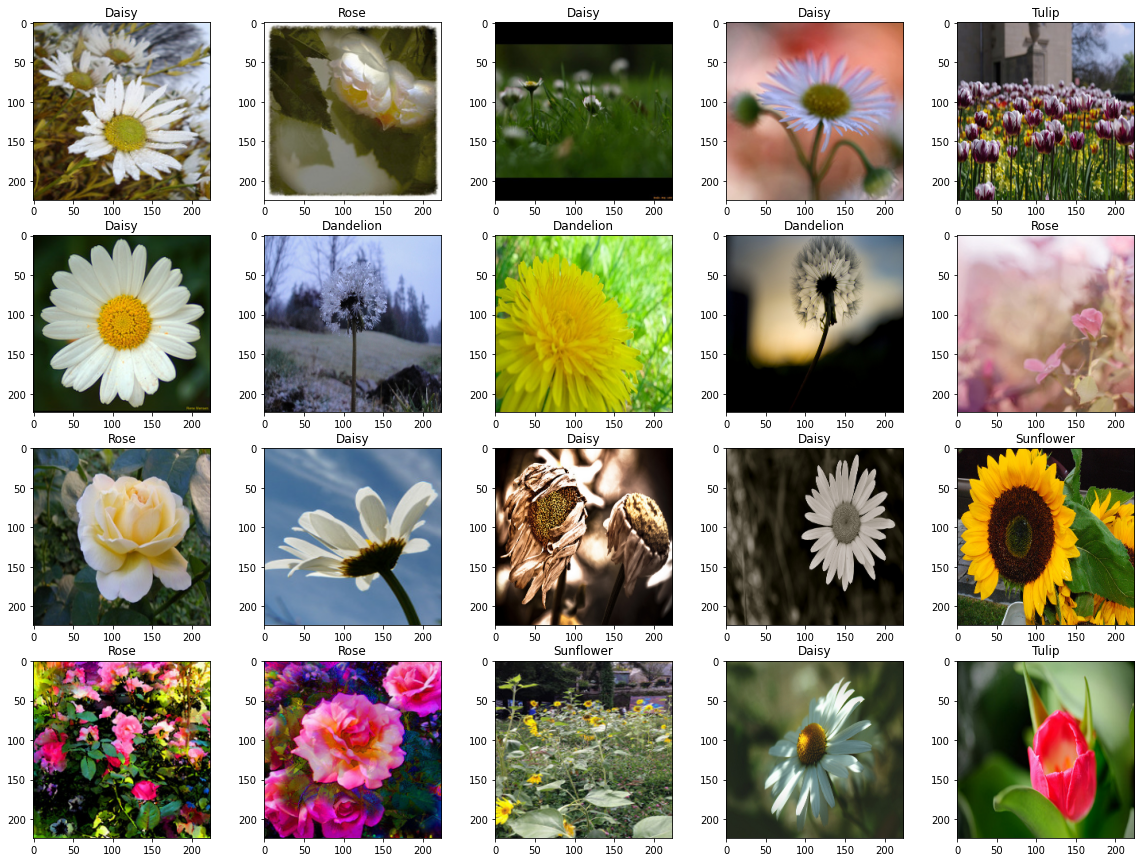

In [ ]:
def flower_name(label):
    if label == 0:
      return 'Daisy'
    elif label == 1:
      return 'Dandelion'
    elif label == 2:
      return 'Rose'
    elif label == 3:
      return 'Sunflower'
    else:
      return 'Tulip'

plt.figure(figsize=(20,15))

for i in range(0, 20):
    plt.subplot(4,5,i+1)  
    plt.imshow(x_train[i])
    plt.title(flower_name(y_train[i]))

---

### Definição de funções 
Exibição do histórico por épocas e teste do modelo.

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc = 'lower left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc = 'upper left')
    plt.show()

In [ ]:
def test(model):
  test_loss, test_acc = model.evaluate(x_test, y_test)
  print(test_loss)
  print(test_acc)

In [ ]:
meus_callbacks = [
                  keras.callbacks.EarlyStopping(patience = 10),
                  keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.00001)
]

---

### CNN simples

In [ ]:
def basic_model():
  model = keras.Sequential()

  model.add( keras.layers.Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)) )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))

  model.add( keras.layers.Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))

  model.add( keras.layers.Conv2D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))

  model.add( keras.layers.Conv2D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))

  model.add( keras.layers.Conv2D(filters = 512, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))

  model.add( keras.layers.Flatten() )
  model.add( keras.layers.Dense(1024, activation = 'relu') )
  model.add( keras.layers.Dense(256, activation = 'relu') )
  model.add( keras.layers.Dense(5, activation = 'softmax') )

  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  model.summary()

  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       8

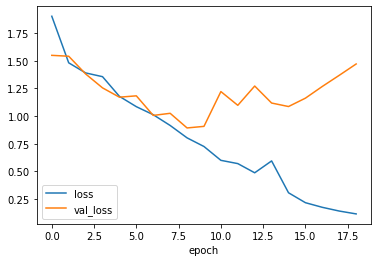

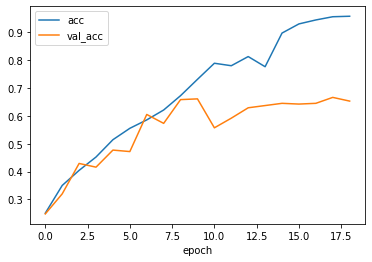

16/16 [==============================] - 1s 78ms/step - loss: 1.6832 - accuracy: 0.6500
1.6831623315811157
0.6499999761581421


In [ ]:
basic_model = basic_model()

tf.random.set_seed(42)

history = basic_model.fit(x = x_train, 
                          y = y_train, 
                          validation_data = (x_val, y_val), 
                          epochs = 30,
                          callbacks = meus_callbacks)
plot_history(history)
test(basic_model)

---

### Adicionando técnicas de regularização e normalização

In [ ]:
def reg_model():
  model = keras.Sequential()

  model.add( keras.layers.Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)) )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))
  model.add(BatchNormalization())

  model.add( keras.layers.Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))
  model.add(BatchNormalization())

  model.add( keras.layers.Conv2D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))
  model.add(BatchNormalization())

  model.add( keras.layers.Conv2D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))
  model.add(BatchNormalization())

  model.add( keras.layers.Conv2D(filters = 512, kernel_size = 5, padding = 'same', activation = 'relu') )
  model.add( keras.layers.MaxPooling2D(pool_size = [2, 2], strides = 2))
  model.add(BatchNormalization())

  model.add( keras.layers.Flatten() )
  model.add( keras.layers.Dense(1024, activation = 'relu') )
  model.add(Dropout(0.33))

  model.add( keras.layers.Dense(256, activation = 'relu') )
  model.add(Dropout(0.33))

  model.add( keras.layers.Dense(5, activation = 'softmax') )

  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  model.summary()

  return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 128)      

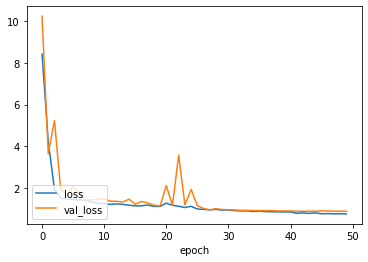

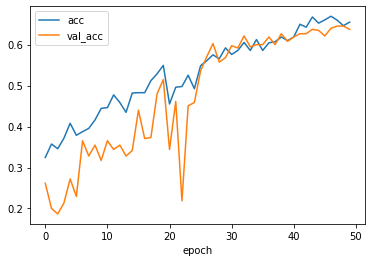

16/16 [==============================] - 0s 29ms/step - loss: 1.0278 - accuracy: 0.6420
1.0277801752090454
0.6420000195503235


In [ ]:
model = reg_model()

tf.random.set_seed(42)

history = model.fit(x = x_train, 
                    y = y_train, 
                    validation_data = (x_val, y_val), 
                    epochs = 50,
                    callbacks = meus_callbacks)
plot_history(history)
test(model)

---

### Aumentando os dados com *data augmentation*

In [ ]:
!pip install imgaug

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops

    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.1,
        iaa.GaussianBlur(sigma=(0, 0.05))
    ),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-10, 10), 
        random_state=42
    )
], random_order = True) # apply augmenters in random order

In [ ]:
meu_escopo = x_train.shape[0]

for batch_idx in range(2):
  x_train = np.vstack((x_train, seq.augment_images(x_train[:meu_escopo])))
  y_train = np.hstack((y_train, y_train[:meu_escopo]))

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3375, 224, 224, 3)
(3375,)
(375, 224, 224, 3)
(375,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       2

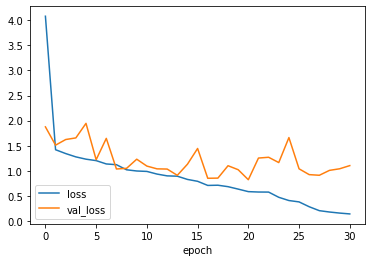

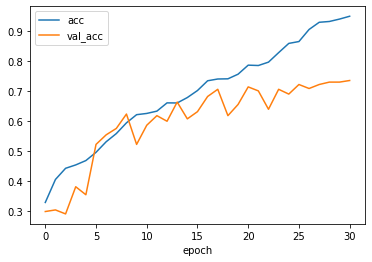

16/16 [==============================] - 1s 81ms/step - loss: 1.2801 - accuracy: 0.7240
1.2801053524017334
0.7239999771118164


In [ ]:
model = reg_model()

tf.random.set_seed(42)

history = model.fit(x = x_train, 
                    y = y_train, 
                    validation_data = (x_val, y_val), 
                    epochs = 50,
                    callbacks = meus_callbacks)
plot_history(history)
test(model)